# Generating a portfolio

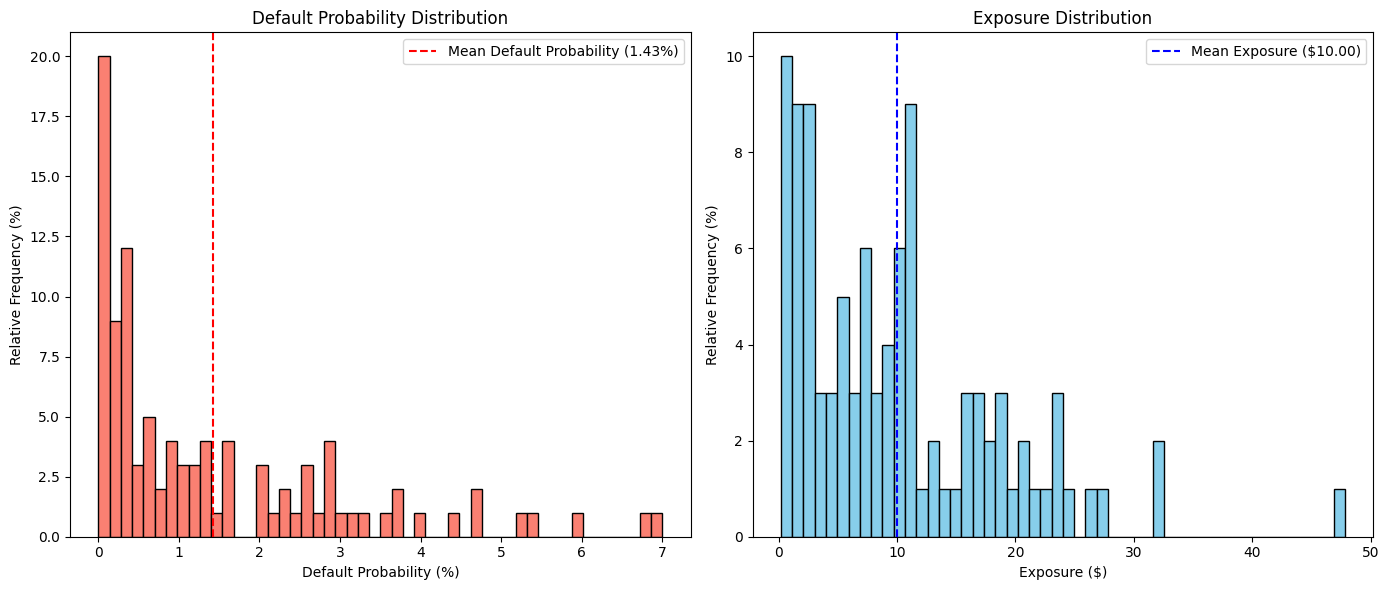

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import Functions as f
from scipy.stats import poisson
import math
from scipy.special import factorial


np.random.seed(10)

num_obligors = 100
total_portfolio_value = 1000
average_exposure = total_portfolio_value / num_obligors

shape_exposure = 1
scale_exposure = average_exposure / np.random.weibull(shape_exposure, num_obligors).mean()
exposures = np.random.weibull(shape_exposure, num_obligors) * scale_exposure

degrees_of_freedom = 1.5  # Adjusted degrees of freedom to reduce spread
scale_factor = 0.07 / np.random.chisquare(degrees_of_freedom, num_obligors).max()  # Ensures max ~ 7%

default_probabilities = np.random.chisquare(degrees_of_freedom, num_obligors) * scale_factor

# Clip values to ensure they stay within 0% and 7%
default_probabilities = np.clip(default_probabilities, 0, 0.07)

portfolio_df = pd.DataFrame({
    'Obligor': range(1, num_obligors + 1),
    'Exposure': exposures,
    'Default_Probability': default_probabilities
})

portfolio_df['Exposure'] = portfolio_df['Exposure'] * (total_portfolio_value / portfolio_df['Exposure'].sum())


bins = 50

exposure_counts, exposure_bins = np.histogram(portfolio_df['Exposure'], bins= bins)
exposure_relative_freq = exposure_counts / num_obligors * 100

default_prob_counts, default_prob_bins = np.histogram(portfolio_df['Default_Probability'] * 100, bins= bins)
default_prob_relative_freq = default_prob_counts / num_obligors * 100

mean_exposure = portfolio_df['Exposure'].mean()
mean_default_prob = (portfolio_df['Default_Probability'] * 100).mean()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(default_prob_bins[:-1], default_prob_relative_freq, width=np.diff(default_prob_bins), color='salmon', edgecolor='black', align='edge')
plt.axvline(mean_default_prob, color='red', linestyle='--', label=f'Mean Default Probability ({mean_default_prob:.2f}%)')
plt.xlabel('Default Probability (%)')
plt.ylabel('Relative Frequency (%)')
plt.title('Default Probability Distribution')
plt.legend()


plt.subplot(1, 2, 2)
plt.bar(exposure_bins[:-1], exposure_relative_freq, width=np.diff(exposure_bins), color='skyblue', edgecolor='black', align='edge')
plt.axvline(mean_exposure, color='blue', linestyle='--', label=f'Mean Exposure (${mean_exposure:.2f})')
plt.xlabel('Exposure ($)')
plt.ylabel('Relative Frequency (%)')
plt.title('Exposure Distribution')
plt.legend()



plt.tight_layout()
plt.show()


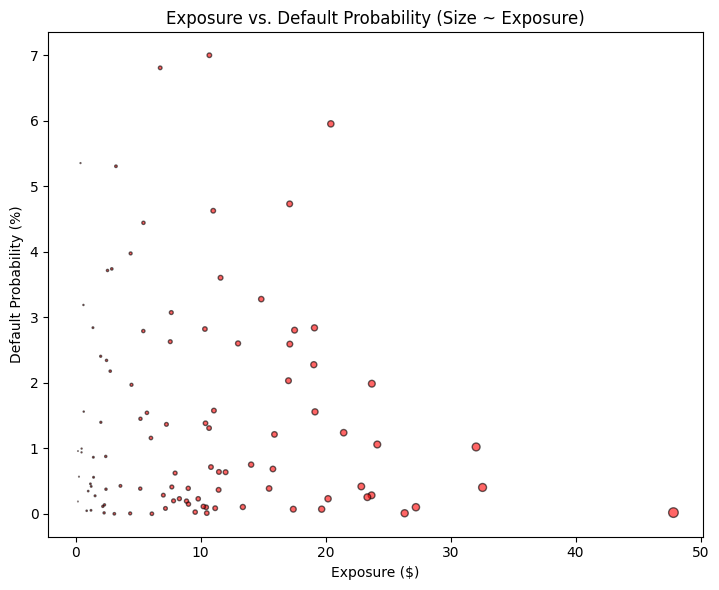

In [2]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(portfolio_df['Exposure'], portfolio_df['Default_Probability'] * 100,
            s=portfolio_df['Exposure'], alpha=0.6, color='red', edgecolor='black')
plt.xlabel('Exposure ($)')
plt.ylabel('Default Probability (%)')
plt.title('Exposure vs. Default Probability (Size ~ Exposure)')

plt.tight_layout()
plt.show()

In [3]:
portfolio_df['Exposure'] = portfolio_df['Exposure'] * (total_portfolio_value / portfolio_df['Exposure'].sum())
portfolio_df

,Obligor,Exposure,Default_Probability
0,1,10.829023,0.007139
1,2,24.136695,0.010584
2,3,0.884904,0.000466
3,4,7.837036,0.001980
4,5,19.109492,0.028392
...,...,...,...
95,96,4.365137,0.000063
96,97,13.379164,0.001041
97,98,20.419579,0.059529
98,99,5.428501,0.044422


In [4]:
total_portfolio_value = portfolio_df['Exposure'].sum()
total_portfolio_value

np.float64(1000.0000000000001)

N = number of obligors \
M = number of iterations \
p = default probabilities \
c = exposures \
alpha = degree of confidence

In [5]:
N = 100  
M = 1000000 
alpha = [0.95, 0.97,0.99, 0.9950, 0.9997, 0.9999]  

p = portfolio_df['Default_Probability'].values  
c = portfolio_df['Exposure'].values
p_mean = np.mean(p)  
c_mean = np.mean(c)
p_var = np.var(p)
#p,c, p_var

In [6]:
correlation = 0.05

In [7]:
results_binomial = pd.DataFrame()
results_poisson = pd.DataFrame()
results_beta_binomial = pd.DataFrame()
results_poisson_gamma = pd.DataFrame()

# The Binomial model

## Simulation

In [8]:
expected_loss_bin, unexpected_loss_bin, var_bin_sim, es_bin_sim = f.independentBinomialSimulation(N, M, p, c, alpha)
results_binomial['Quantile (alpha)'] = alpha
results_binomial['Expected Loss (Sim)'] = [expected_loss_bin] * len(alpha)
results_binomial['Unexpected Loss (Sim)'] = [unexpected_loss_bin] * len(alpha)
results_binomial['VaR (Sim)'] = var_bin_sim
results_binomial['ES (Sim)'] = es_bin_sim

## Analytic

In [9]:
pmfBinomial, cdfBinomial, var_bin_analytic, es_bin_analytic = f.independentBinomialAnalytic(N, p_mean, c_mean, alpha)
results_binomial['VaR (Analytic)'] = var_bin_analytic
results_binomial['ES (Analytic)'] = es_bin_analytic
results_binomial

,Quantile (alpha),Expected Loss (Sim),Unexpected Loss (Sim),VaR (Sim),ES (Sim),VaR (Analytic),ES (Analytic)
0,0.9500,13.304262,13.758634,39.989364,49.968217,31.417546,31.679281
1,0.9700,13.304262,13.758634,45.323770,54.945976,36.280161,36.564293
2,0.9900,13.304262,13.758634,56.124187,64.919135,44.103065,44.425980
3,0.9950,13.304262,13.758634,62.352968,70.914475,48.467793,48.683340
4,0.9997,13.304262,13.758634,86.803533,94.044957,66.120453,66.422853
5,0.9999,13.304262,13.758634,94.995084,101.230186,70.134475,70.428565


# Poisson model

## Simulation

In [10]:
lossDistribution_poisson = f.independentPoissonLossDistribution(N, M, p, c, alpha)
expected_loss_poisson, unexpected_loss_poisson, var_poisson_sim, es_poisson_sim = f.computeRiskMeasures(M, lossDistribution_poisson, alpha)
results_poisson['Quantile (alpha)'] = alpha
results_poisson['Expected Loss (Sim)'] = [expected_loss_poisson] * len(alpha)
results_poisson['Unexpected Loss (Sim)'] = [unexpected_loss_poisson] * len(alpha)
results_poisson['VaR (Sim)'] = var_poisson_sim
results_poisson['ES (Sim)'] = es_poisson_sim

## Analytic

In [11]:
myLam = np.mean(-np.log(1 - p))
pmfPoisson, cdfPoisson, var_poisson_analytic, es_poisson_analytic = f.independentPoissonAnalytic(N, c_mean, myLam, alpha)
results_poisson['VaR (Analytic)'] = var_poisson_analytic
results_poisson['ES (Analytic)'] = es_poisson_analytic
results_poisson

,Quantile (alpha),Expected Loss (Sim),Unexpected Loss (Sim),VaR (Sim),ES (Sim),VaR (Analytic),ES (Analytic)
0,0.9500,13.281959,13.756929,40.034271,49.957973,0.000000,0.007158
1,0.9700,13.281959,13.756929,45.296608,54.923345,0.000000,0.015930
2,0.9900,13.281959,13.756929,56.019613,64.910784,3.094515,3.399361
3,0.9950,13.281959,13.756929,62.402885,70.960954,6.583783,6.729229
4,0.9997,13.281959,13.756929,85.810787,93.454243,9.863695,9.909773
5,0.9999,13.281959,13.756929,94.210565,101.970362,10.449237,10.633088


# Beta-Binomial

In [12]:
a, b = f.calibrate_beta_parameters_with_correlation(p_mean, correlation)
a,b

(np.float64(0.271675424260514), np.float64(18.72832457573948))

In [13]:
a_beta, b_beta = f.calibrate_beta_parameters_with_means(p_mean, p_var)
a_beta, b_beta

(np.float64(0.7522139221990491), np.float64(51.85491666638536))

## Simulation

In [14]:
lossDistribution_beta_binomial = f.independentBinomialLossDistribution(N, M, p, c, alpha)
expected_loss_beta_binomial, unexpected_loss_beta_binomial, var_beta_binomial_sim, es_beta_binomial_sim = f.computeRiskMeasures(M, lossDistribution_beta_binomial, alpha)
results_beta_binomial['Quantile (alpha)'] = alpha
results_beta_binomial['Expected Loss (Sim)'] = [expected_loss_beta_binomial] * len(alpha)
results_beta_binomial['Unexpected Loss (Sim)'] = [unexpected_loss_beta_binomial] * len(alpha)
results_beta_binomial['VaR (Sim)'] = var_beta_binomial_sim
results_beta_binomial['ES (Sim)'] = es_beta_binomial_sim

## Analytic

In [15]:
pmfBeta, cdfBeta, var_beta_binomial_analytic, es_beta_binomial_analytic = f.betaBinomialAnalytic(N, c_mean, a, b, alpha)
results_beta_binomial['VaR (Analytic)'] = var_beta_binomial_analytic
results_beta_binomial['ES (Analytic)'] = es_beta_binomial_analytic
results_beta_binomial

,Quantile (alpha),Expected Loss (Sim),Unexpected Loss (Sim),VaR (Sim),ES (Sim),VaR (Analytic),ES (Analytic)
0,0.9500,13.290147,13.748454,40.043172,49.937175,67.463961,69.313351
1,0.9700,13.290147,13.748454,45.345751,54.874857,88.104991,89.028532
2,0.9900,13.290147,13.748454,56.097588,64.719430,134.148874,176.338347
3,0.9950,13.290147,13.748454,62.395946,70.566434,163.388710,205.135310
4,0.9997,13.290147,13.748454,84.665205,91.812399,278.584870,316.943681
5,0.9999,13.290147,13.748454,93.185522,99.343381,320.936550,357.725106


# Poisson-Gamma

## Simulation

In [16]:
correlation = 0.05

In [17]:
a, b = f.calibrate_beta_parameters_with_correlation(p_mean, correlation)
a_1,b_1 = f.dirty_calibration(correlation, p_mean)
a,b,a_1,b_1

(np.float64(0.271675424260514),
 np.float64(18.72832457573948),
 np.float64(0.2901225073944309),
 np.float64(20.290122507394432))

In [18]:
expected_loss_pg, unexpected_loss_pg, var_pg_sim, es_pg_sim = f.poissonGammaSimulation(N, M, c, a, b, alpha)
results_poisson_gamma['Quantile (alpha)'] = alpha
results_poisson_gamma['Expected Loss (Sim)'] = [expected_loss_pg] * len(alpha)
results_poisson_gamma['Unexpected Loss (Sim)'] = [unexpected_loss_pg] * len(alpha)
results_poisson_gamma['VaR (Sim)'] = var_pg_sim
results_poisson_gamma['ES (Sim)'] = es_pg_sim

## Analytic

In [19]:
pmfPG, cdfPG, var_pg_analytic, es_pg_analytic = f.poissonGammaAnalytic(N, c_mean, a, b, alpha)
results_poisson_gamma['VaR (Analytic)'] = var_pg_analytic
results_poisson_gamma['ES (Analytic)'] = es_pg_analytic
results_poisson_gamma

,Quantile (alpha),Expected Loss (Sim),Unexpected Loss (Sim),VaR (Sim),ES (Sim),VaR (Analytic),ES (Analytic)
0,0.9500,14.064068,30.208939,74.803227,118.244246,0.000000,0.006714
1,0.9700,14.064068,30.208939,96.714621,140.539886,0.000000,0.014763
2,0.9900,14.064068,30.208939,145.490886,188.792898,2.970126,3.357267
3,0.9950,14.064068,30.208939,176.187993,218.384723,6.652665,6.934795
4,0.9997,14.064068,30.208939,296.578358,336.784767,13.544907,13.831238
5,0.9999,14.064068,30.208939,342.486362,380.735161,18.115276,18.478398
